In [2]:
import urllib
import pyodbc
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import matplotlib as mpl
import statsmodels.api as sm
import multiprocessing as mp

from multiprocessing import Process
import matplotlib.pyplot as plt
import matplotlib
# from tqdm import tqdm_notebook as tqdm
from importlib import reload
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2 as ctable

In [3]:
def set_style():
    matplotlib.rcdefaults() 
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 30}
    
    legend = {'fontsize': 10,
              'handlelength': 2}
    matplotlib.rc("font", **font)
    matplotlib.rc("legend", **legend)

In [4]:
hy_db = 'hy180_2021'

with open('dbmi-aetna-cxn-str') as f:
    cxn_params = f.read().strip()
    gmw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=gmw3')
    aetna_raw_cxn_str = urllib.parse.quote_plus(cxn_params + 'Database=AetnaDataWarehouse')
    hy_cxn_str = urllib.parse.quote_plus(cxn_params + f'Database={hy_db}')
    
engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % gmw_cxn_str, connect_args = {'autocommit':True})
cxn = engine.connect()
ins = sqla.inspect(engine)

hy_engine = sqla.create_engine("mssql+pyodbc:///?odbc_connect=%s" % hy_cxn_str, connect_args = {'autocommit': True, 'fast_executemany': True}, pool_size=100)
hy_cxn = hy_engine.connect()

# Glucose tests per age 

## Data

In [5]:
# temp table for glucose tests per patient
glucose_tests_cpt = ('82947', )
glucose_panels_cpt = ('80047', '80048', '80053', '80069')
a1c_tests_cpt = ('83036', )
all_tests_cpt = glucose_tests_cpt + glucose_panels_cpt + a1c_tests_cpt

tmp_query = ("drop table if exists #hytmp; drop table if exists #patientBYCount;"
            " select MemberNum, datepart(yyyy, DateServiceStarted) as year, LineLevelProcedureCode as cpt "
            "  into #hytmp from ObservationProcedure with (nolock) "
           f"  where LineLevelProcedureCodeType='C' and LineLevelProcedureCode in {str(all_tests_cpt)};"
            " sele¡ct BirthYearMinus1900, count(*) as byearCount"
            "  into #patientBYCount"
            "  from gmw3.dbo.Member"
            "  group by BirthYearMinus1900")
cxn.execute(tmp_query)

# count glucose measurements in each byear bucket per year
query = ("select t2.year, (1. * count(*))/byearCount as testsPerBY, 119 - t1.BirthYearMinus1900 as age"
        " from Member as t1 "
        " join #hytmp as t2 on t1.MemberNum=t2.MemberNum"
        " join #patientBYCount as t3 on t1.BirthYearMinus1900=t3.BirthYearMinus1900"
        " group by year, t1.BirthYearMinus1900, byearCount;")
glucose_per_year = pd.read_sql(query, cxn)
glucose_per_year.to_csv('figdata/glucose_per_year.csv')

## Figure

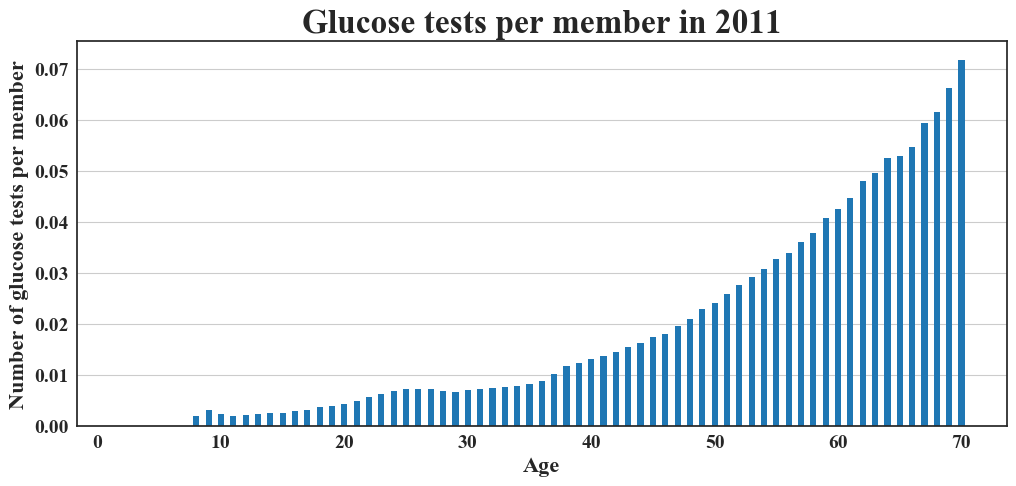

<Figure size 640x440 with 0 Axes>

In [8]:
set_style()
glucose_per_year = pd.read_csv('figdata/glucose_per_year.csv', index_col=0)

age_thres = 71
year = 2011

data = glucose_per_year.loc[(glucose_per_year.year == year) & (glucose_per_year.age < age_thres)].sort_values(by='age', ascending=True)

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
ax.yaxis.grid(True)
bars = ax.bar(x=data.age.values, height=data.testsPerBY, align='center', width=.5)

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Number of glucose tests per member', fontsize=16)
plt.title('Glucose tests per member in 2011', fontsize=24)
plt.show()
plt.savefig('./figures/figure3.eps', dpi=300)

# Age distributions

## Data

In [4]:
def age_counts(group_table=None, cxn=cxn):
    if group_table is None:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member"
                " group by BirthYearMinus1900")
    else:
        query = ("select 119 - BirthYearMinus1900 as age, count(*) as ageCount"
                " from gmw3.dbo.Member as t1"
                " inner join %s as t2"
                " on t1.MemberNum=t2.MemberNum"
                " group by BirthYearMinus1900"
                % group_table)
    
    results = pd.read_sql(query, cxn)
    return results

In [6]:
groups = [f'{hy_db}.dbo.t2dCaseEmerge', f'{hy_db}.dbo.t2dControlEmerge', f'{hy_db}.dbo.t2dControlEmergeIgnoreLabValue', f'{hy_db}.dbo.t2dControlEmergeIgnoreLab', f'{hy_db}.dbo.t2dControlEmergeNoLab', f'{hy_db}.dbo.t2dControlEmergeNoLabMatched']
labels = ['Case', 'Baseline Control', 'Ignore Lab Value', 'Ignore Lab', 'No Lab', 'No lab matched']

data = pd.DataFrame(columns=['age', 'ageCount', 'label'])
for group, label in zip(groups, labels):
    dist = age_counts(group)
    dist['label'] = label
    data = pd.concat([data, dist])
    
data.to_csv('figdata/age_distributions.csv')

## Figure

In [7]:
def age_histogram(results, ax=None, label_axes=True, **plot_params):
    if not ax: ax = plt.subplot(111)
    ax.bar(x=results.age.values, height=results.ageCount, **plot_params)

    ax.tick_params(axis='both', which='major', labelsize=10)
    
    if label_axes:
        ax.set_ylabel('# of Members', fontsize=16)
        

<Figure size 640x440 with 0 Axes>

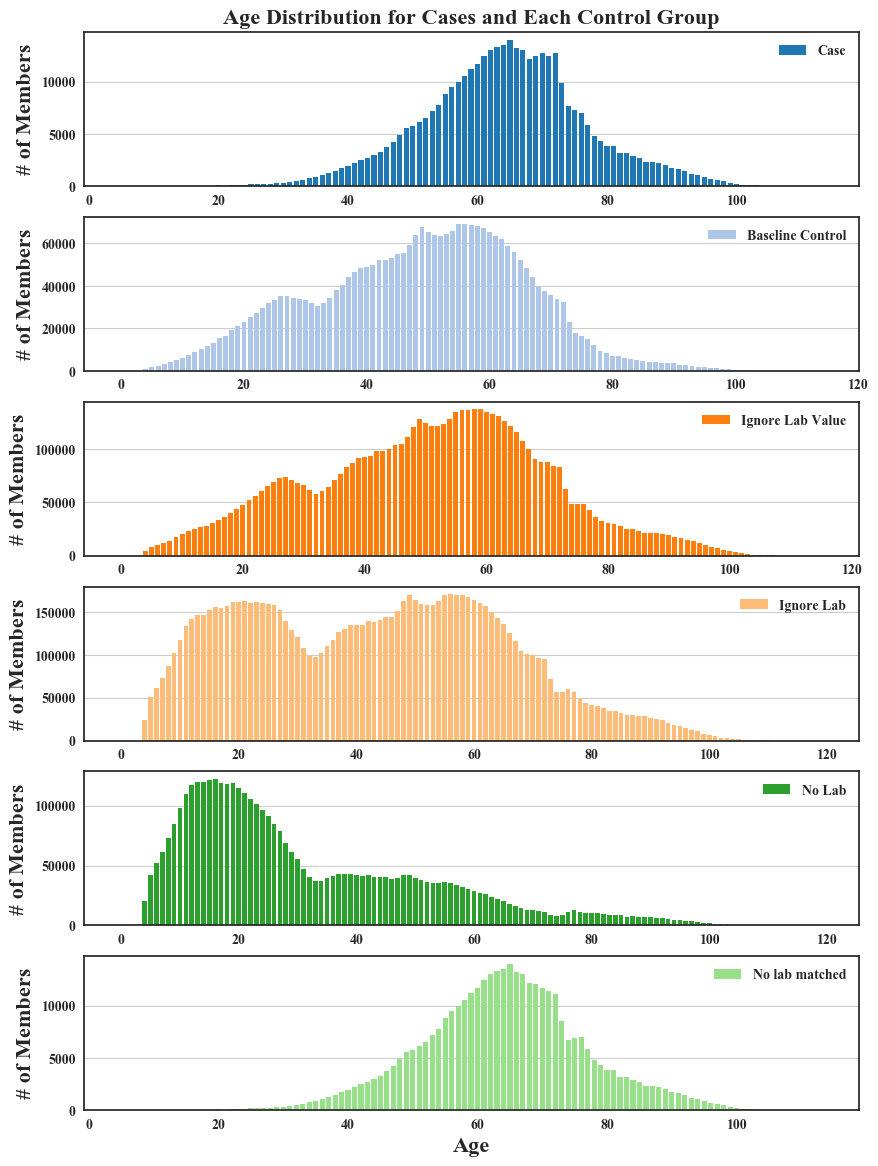

In [8]:
data = pd.read_csv('figdata/age_distributions.csv')

set_style()
fig = plt.figure()
f, axes = plt.subplots(6, 1, figsize=(10, 14))
labels = ['Case', 'Baseline Control', 'Ignore Lab Value', 'Ignore Lab', 'No Lab', 'No lab matched']
cmap = mpl.cm.tab20

axes[0].set_title('Age Distribution for Cases and Each Control Group', fontsize=16)
for i, (ax, label) in enumerate(zip(axes, labels)):
    dist = age_histogram(results=data[data.label==label], ax=ax, label_axes=True, color=cmap(i))
    ax.legend([label])
    ax.yaxis.grid(True)

plt.xlabel('Age', fontsize=16)
plt.ylabel('# of Members', fontsize=16)

# plt.show()
plt.savefig('./figures/figure4.eps', dpi=300)

# Association ORs

## Data

In [5]:
matched_results = pd.read_csv('results/updated_matched_control_definitions_bootstrap.csv')
matched_results['matching'] = 'age and gender'
unmatched_results = pd.read_csv('results/updated_control_definitions_bootstrap.csv')
unmatched_results['matching'] = 'none'

results = pd.concat([unmatched_results, matched_results], join='inner')
results['p < .05'] = results.p_value < .05
results['ci_width'] = results.ci95_upper - results.ci95_lower

In [6]:
print(results)

      Unnamed: 0                control  samp_size        OR        p_value  \
0              0       t2dControlEmerge       2000  1.241722   9.949661e-03   
1              1       t2dControlEmerge       2000  1.183099   5.223342e-02   
2              2       t2dControlEmerge       2000  1.194946   4.517200e-02   
3              3       t2dControlEmerge       2000  1.144366   1.279017e-01   
4              4       t2dControlEmerge       2000  1.370370   2.475368e-04   
5              5       t2dControlEmerge       2000  1.182410   4.969185e-02   
6              6       t2dControlEmerge       2000  1.412879   5.966551e-05   
7              7       t2dControlEmerge       2000  1.189964   5.054716e-02   
8              8       t2dControlEmerge       2000  1.298246   2.086493e-03   
9              9       t2dControlEmerge       2000  1.220000   1.905192e-02   
10            10       t2dControlEmerge       2000  1.274021   4.905901e-03   
11            11       t2dControlEmerge       2000  

In [7]:
print(results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] == 'none')] ['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_upper'].median(), 
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci_width'].median())


print(results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_lower'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] == 'none')]['ci_width'].median())

print('\n \n')
print(results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] == 'none')] ['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_lower'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci95_upper'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] == 'none')]['ci_width'].median())





1.2281879194630871 1.037302813773235 1.452616103450297 0.4131892632527042
1.1706983492697778 0.9897831387031817 1.3822215857832059 0.3896080117346813
1.612447315374748 1.3480819986954233 1.9363128236722638 0.5868413022022212
4.2682926829268295 3.3297302878505315 5.4696653591817554 2.144358828560577

 

1.224362851289491 1.1353722204123806 1.320260146038263 0.18442008087229111
1.1765964658855368 1.0926441418538468 1.2681608541026332 0.1751905683490066
1.6362796944514395 1.50872891599761 1.7741819707587785 0.26439923941344157
4.19268183846497 3.7538449481678873 4.685657875805944 0.9306041697784502


In [8]:
print(results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] != 'none')] ['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_upper'].median(), 
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci_width'].median())


print(results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_lower'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 2000) & (results['matching'] != 'none')]['ci_width'].median())

print('\n \n')
print(results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] != 'none')] ['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmerge') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLabValue') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_lower'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_upper'].median(),
     results[(results['control']=='t2dControlEmergeIgnoreLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci_width'].median())

print(results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['OR'].median(), 
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_lower'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci95_upper'].median(),
      results[(results['control']=='t2dControlEmergeNoLab') & (results['samp_size'] == 10000) & (results['matching'] != 'none')]['ci_width'].median())


1.2856668072758881 1.0861575483488526 1.5246631580847154 0.43896624028836273
1.1732731554160125 0.9945503834481191 1.3852128347453796 0.39349705821909114
1.314022429174707 1.107647813390876 1.5605360080467647 0.4507108639856269
2.662943855990341 2.161844135024804 3.2815476476187126 1.1190945317466159

 

1.2769918850179074 1.1831266484725758 1.3780418856330428 0.1941297507619294
1.1684466303569265 1.0847972598442381 1.2588844081410553 0.1742586382759448
1.3094212203862305 1.212670811149222 1.4130320718986948 0.20031068922338668
2.6553679869482463 2.4166962461255714 2.917514746987243 0.4980235656418863


In [20]:
results[(results.control=='t2dControlEmergeIgnoreLabValue') & (results.matching != 'none') & (results.samp_size == 2000)]

,Unnamed: 0,control,samp_size,OR,p_value,ci95_lower,ci95_upper,matching,p < .05,ci_width
400,400,t2dControlEmergeIgnoreLabValue,2000,1.142361,0.130088,0.963895,1.353871,age and gender,False,0.389976
401,401,t2dControlEmergeIgnoreLabValue,2000,1.241042,0.009315,1.054806,1.460160,age and gender,True,0.405354
402,402,t2dControlEmergeIgnoreLabValue,2000,1.304029,0.002302,1.100801,1.544777,age and gender,True,0.443976
403,403,t2dControlEmergeIgnoreLabValue,2000,1.100694,0.275752,0.927534,1.306181,age and gender,False,0.378647
404,404,t2dControlEmergeIgnoreLabValue,2000,1.185185,0.046718,1.003505,1.399757,age and gender,True,0.396252
405,405,t2dControlEmergeIgnoreLabValue,2000,1.152597,0.093550,0.977548,1.358993,age and gender,False,0.381446
406,406,t2dControlEmergeIgnoreLabValue,2000,1.135048,0.131671,0.962836,1.338062,age and gender,False,0.375226
407,407,t2dControlEmergeIgnoreLabValue,2000,1.142373,0.123438,0.965599,1.351509,age and gender,False,0.385910
408,408,t2dControlEmergeIgnoreLabValue,2000,1.068452,0.434985,0.909413,1.255305,age and gender,False,0.345891
409,409,t2dControlEmergeIgnoreLabValue,2000,1.185567,0.049522,1.002364,1.402254,age and gender,True,0.399891


## Figure

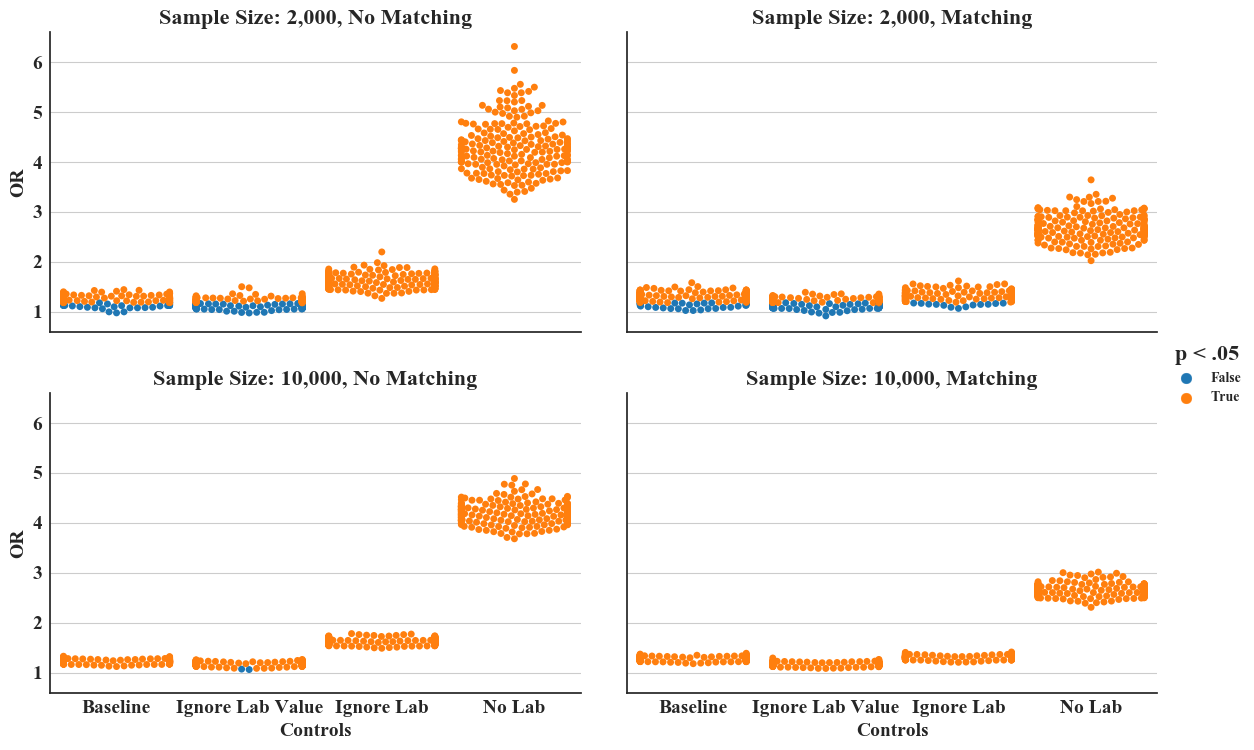

In [24]:
set_style()

g = sns.catplot(kind='swarm', data=results, row='samp_size', col='matching', 
                x='control', y='OR', hue='p < .05', 
                order=['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 
                       't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab'], 
                  row_order=[2000, 10000], height=4, aspect=1.5).set_xticklabels(['Baseline', 'Ignore Lab Value', 'Ignore Lab', 'No Lab'], ha='center')

g.axes[0,0].yaxis.grid(True)
g.axes[0,1].yaxis.grid(True)
g.axes[1,0].yaxis.grid(True)
g.axes[1,1].yaxis.grid(True)

g.axes[0,0].set_title('Sample Size: 2,000, No Matching', fontsize=16)
g.axes[0,1].set_title('Sample Size: 2,000, Matching', fontsize=16)
g.axes[1,0].set_title('Sample Size: 10,000, No Matching', fontsize=16)
g.axes[1,1].set_title('Sample Size: 10,000, Matching', fontsize=16)


g.axes[0,0].tick_params(axis='both', which='major', labelsize=14)
g.axes[0,1].tick_params(axis='both', which='major', labelsize=14)
g.axes[1,0].tick_params(axis='both', which='major', labelsize=14)
g.axes[1,1].tick_params(axis='both', which='major', labelsize=14)

g.axes[1,0].set_xlabel('Controls', fontsize=14)
g.axes[1,1].set_xlabel('Controls', fontsize=14)

g.axes[0,0].set_ylabel('OR', fontsize=14)
g.axes[1,0].set_ylabel('OR', fontsize=14)

# g.add_legend(fontsize=16)
plt.setp(g._legend.get_title(), fontsize=16)

# plt.show()
plt.savefig('./figures/figure5.eps', dpi=300)

In [29]:
# Rows matched, cols matched
groups = ['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab']
rows = []
for group_a in groups:
    rows.append([group_a] + [stats.ttest_ind(results[(results.samp_size==10000) & (results.control==group_a) & (results.matching=='none')].OR, 
                           results[(results.samp_size==10000) & (results.control==group_b) & (results.matching=='none')].OR).pvalue
           for group_b in groups])

pd.DataFrame.from_records(columns=[''] + groups, data=rows)

,,t2dControlEmerge,t2dControlEmergeIgnoreLabValue,t2dControlEmergeIgnoreLab,t2dControlEmergeNoLab
0,t2dControlEmerge,1.000000e+00,2.551867e-06,1.333136e-262,0.0
1,t2dControlEmergeIgnoreLabValue,2.551867e-06,1.000000e+00,9.805744e-270,0.0
2,t2dControlEmergeIgnoreLab,1.333136e-262,9.805744e-270,1.000000e+00,0.0
3,t2dControlEmergeNoLab,0.000000e+00,0.000000e+00,0.000000e+00,1.0


In [8]:
# Rows unmatched, cols matched
groups = ['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab']
rows = []
for group_a in groups:
    rows.append([group_a] + [stats.ttest_ind(results[(results.samp_size==10000) & (results.control==group_a) & (results.matching=='none')].OR, 
                           results[(results.samp_size==10000) & (results.control==group_b) & (results.matching!='none')].OR).pvalue
           for group_b in groups])

pd.DataFrame.from_records(columns=[''] + groups, data=rows)

,,t2dControlEmerge,t2dControlEmergeIgnoreLabValue,t2dControlEmergeIgnoreLab,t2dControlEmergeNoLab
0,t2dControlEmerge,7.038615e-40,7.665126e-08,2.347074e-99,0.000000e+00
1,t2dControlEmergeIgnoreLabValue,1.251240e-71,4.487414e-31,2.135904e-128,0.000000e+00
2,t2dControlEmergeIgnoreLab,5.456780e-237,7.453870e-253,9.323356e-208,1.524378e-286
3,t2dControlEmergeNoLab,0.000000e+00,0.000000e+00,0.000000e+00,1.033782e-262


In [9]:
# rows matched, col matched
groups = ['t2dControlEmerge', 't2dControlEmergeIgnoreLabValue', 't2dControlEmergeIgnoreLab', 't2dControlEmergeNoLab']
rows = []
for group_a in groups:
    rows.append([group_a] + [stats.ttest_ind(results[(results.samp_size==10000) & (results.control==group_a) & (results.matching!='none')].OR, 
                           results[(results.samp_size==10000) & (results.control==group_b) & (results.matching!='none')].OR).pvalue
           for group_b in groups])

pd.DataFrame.from_records(columns=[''] + groups, data=rows)

,,t2dControlEmerge,t2dControlEmergeIgnoreLabValue,t2dControlEmergeIgnoreLab,t2dControlEmergeNoLab
0,t2dControlEmerge,1.000000e+00,1.510231e-18,8.424882e-37,0.0
1,t2dControlEmergeIgnoreLabValue,1.510231e-18,1.000000e+00,8.416514e-76,0.0
2,t2dControlEmergeIgnoreLab,8.424882e-37,8.416514e-76,1.000000e+00,0.0
3,t2dControlEmergeNoLab,0.000000e+00,0.000000e+00,0.000000e+00,1.0


# Demographics

In [8]:
def default_enroll_window_agg(select_cols,
                          claims_table, 
                          claim_date_col,
                          group_by_col='MemberNum',
                          enrollment_table=f'{hy_db}.dbo.EnrollFourPlusYears', 
                          window_date_col='enrollDatePlusFourYears',
                          enroll_date_col='enrollDate',
                          join_col='MemberNum'):
    
    select_cols.append(f't1.{join_col}')
    return (f"select {','.join(select_cols)}"
       f" from {claims_table} as t1 inner join {enrollment_table} as t2"
       f" on t1.{join_col}=t2.{join_col}"
       f" where {claim_date_col} between {enroll_date_col} and {window_date_col}"
       f" group by t1.{group_by_col}")

In [ ]:
group = f'{hy_db}.dbo.t2dCaseEmergeNoLabMatched'

num_members = cxn.execute(f'select count(*) from {group}').fetchone()[0]
num_males = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='M'").fetchone()[0]
num_females = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='F'").fetchone()[0]
age_mean, age_std = cxn.execute(f"select avg(age), stdev(age) from {group} as t1 join (select MemberNum, 119 - Birthyearminus1900 as age from Member) as t2 on t1.MemberNum=t2.MemberNum").fetchone()
num_with_depression = cxn.execute(f"select count(*) from {group} as t1 join {hy_db}.dbo.depressionCase as t2 on t1.MemberNum=t2.MemberNum").fetchone()[0]
fact_count_mean, fact_count_std = cxn.execute(f"select avg(factCount) / 4. as mean, stdev(factCount / 4.) as std from ({default_enroll_window_agg(['count(*) as factCount'], 'ObservationDiagnosis', 'StartDate')}) as t inner join {group} as t1 on t.MemberNum=t1.MemberNum").fetchone()


In [22]:
cxn.execute(f"select avg(cast(factCount as float)) / 4. as mean, stdev(factCount / 4.) as std from ({default_enroll_window_agg(['count(*) as factCount'], 'ObservationDiagnosis', 'StartDate')}) as t inner join {group} as t1 on t.MemberNum=t1.MemberNum").fetchone()

(27.50002089788458, 31.77587739132505)

In [10]:
# groups = [f'{hy_db}.dbo.t2dControlEmergeIgnoreLabValue', ]
groups = [f'{hy_db}.dbo.t2dCaseEmerge', f'{hy_db}.dbo.t2dControlEmerge', f'{hy_db}.dbo.t2dControlEmergeIgnoreLabValue', f'{hy_db}.dbo.t2dControlEmergeIgnoreLab', f'{hy_db}.dbo.t2dControlEmergeNoLab',] # f'{hy_db}.dbo.t2dCaseEmergeNoLabMatched', f'{hy_db}.dbo.t2dControlEmergeNoLabMatched']

rows = []
for group in groups:
    num_members = cxn.execute(f'select count(*) from {group}').fetchone()[0]
    num_males = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='M'").fetchone()[0]
    num_females = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='F'").fetchone()[0]
    age_mean, age_std = cxn.execute(f"select avg(cast(age as float)), stdev(cast(age as float)) from {group} as t1 join (select MemberNum, 119 - Birthyearminus1900 as age from Member) as t2 on t1.MemberNum=t2.MemberNum").fetchone()
    num_with_depression = cxn.execute(f"select count(*) from {group} as t1 join {hy_db}.dbo.depressionCase as t2 on t1.MemberNum=t2.MemberNum").fetchone()[0]
    fact_count_mean, fact_count_std = cxn.execute(f"select avg(cast(factCount as float)) / 4. as mean, stdev(factCount / 4.) as std from ({default_enroll_window_agg(['count(*) as factCount'], 'ObservationDiagnosis', 'StartDate')}) as t inner join {group} as t1 on t.MemberNum=t1.MemberNum").fetchone()
    rows.append((group, num_members, num_males, num_females, age_mean, age_std, num_with_depression, fact_count_mean, fact_count_std))
    
demographics = pd.DataFrame(columns=['group', 'num_members', 'num_males', 'num_females', 'age_mean', 'age_std', 'num_with_depression', 'fact_count_mean', 'fact_count_std'], data=rows)

In [22]:
demographics['percent_male'] = 100 * (demographics.num_males / demographics.num_members)
demographics['percent_female'] = 100 * demographics.num_females / demographics.num_members
demographics['percent_with_depression'] = 100 * (demographics.num_with_depression / demographics.num_members)
demographics['age_print'] = demographics.apply(func=lambda row: '%.2f (%.2f)' % (row.age_mean, row.age_std), axis='columns')
demographics['fact_count_print'] = demographics.apply(func=lambda row: '%.2f (%.2f)' % (row.fact_count_mean, row.fact_count_std), axis='columns')

In [19]:
demographics[['group', 'num_members', 'percent_male', 'percent_female', 'age_print', 'percent_with_depression', 'fact_count_print']].T

,0,1,2,3,4
group,hy180_2021.dbo.t2dCaseEmerge,hy180_2021.dbo.t2dControlEmerge,hy180_2021.dbo.t2dControlEmergeIgnoreLabValue,hy180_2021.dbo.t2dControlEmergeIgnoreLab,hy180_2021.dbo.t2dControlEmergeNoLab
num_members,381412,2868491,6204015,10286072,4054244
percent_male,51.9,42.8982,45.0855,47.8358,52.104
percent_female,48.0981,57.0983,54.9119,52.1611,47.8918
age_print,64.16 (12.47),48.70 (17.04),50.74 (19.19),43.12 (21.99),31.29 (20.69)
percent_with_depression,17.511,14.2421,14.9391,10.7044,4.22126
fact_count_print,53.54 (55.10),25.91 (29.86),29.07 (34.29),21.99 (29.54),11.12 (14.64)


In [20]:
groups = [f'{hy_db}.dbo.t2dCaseEmergeNoLabMatched', f'{hy_db}.dbo.t2dControlEmergeNoLabMatched']

rows = []
for group in groups:
    num_members = cxn.execute(f'select count(*) from {group}').fetchone()[0]
    num_males = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='M'").fetchone()[0]
    num_females = cxn.execute(f"select count(*) from {group} as t1 join Member as t2 on t1.MemberNum=t2.MemberNum where gender='F'").fetchone()[0]
    age_mean, age_std = cxn.execute(f"select avg(age), stdev(age) from {group} as t1 join (select MemberNum, 119 - Birthyearminus1900 as age from Member) as t2 on t1.MemberNum=t2.MemberNum").fetchone()
    num_with_depression = cxn.execute(f"select count(*) from {group} as t1 join {hy_db}.dbo.depressionCase as t2 on t1.MemberNum=t2.MemberNum").fetchone()[0]
    fact_count_mean, fact_count_std = cxn.execute(f"select avg(factCount) / 4. as mean, stdev(factCount / 4.) as std from ({default_enroll_window_agg(['count(*) as factCount'], 'ObservationDiagnosis', 'StartDate')}) as t inner join {group} as t1 on t.MemberNum=t1.MemberNum").fetchone()
    rows.append((group, num_members, num_males, num_females, age_mean, age_std, num_with_depression, fact_count_mean, fact_count_std))
    
demographics = pd.DataFrame(columns=['group', 'num_members', 'num_males', 'num_females', 'age_mean', 'age_std', 'num_with_depression', 'fact_count_mean', 'fact_count_std'], data=rows)

In [22]:
demographics['percent_male'] = 100 * (demographics.num_males / demographics.num_members)
demographics['percent_female'] = 100 * demographics.num_females / demographics.num_members
demographics['percent_with_depression'] = 100 * (demographics.num_with_depression / demographics.num_members)
demographics['age_print'] = demographics.apply(func=lambda row: '%.2f (%.2f)' % (row.age_mean, row.age_std), axis='columns')
demographics['fact_count_print'] = demographics.apply(func=lambda row: '%.2f (%.2f)' % (row.fact_count_mean, row.fact_count_std), axis='columns')

In [23]:
demographics[['group', 'num_members', 'percent_male', 'percent_female', 'age_print', 'percent_with_depression', 'fact_count_print']].T

,0,1
group,hy180_2021.dbo.t2dCaseEmergeNoLabMatched,hy180_2021.dbo.t2dControlEmergeNoLabMatched
num_members,374719,374719
percent_male,51.0433,51.0433
percent_female,48.9567,48.9567
age_print,64.00 (12.54),64.00 (12.54)
percent_with_depression,17.6148,6.60708
fact_count_print,53.25 (55.11),13.50 (18.85)
